<a href="https://colab.research.google.com/github/AminFathollahi/NMA_DL/blob/main/tutorials/W2D2_NeuroSymbolicMethods/student/W2D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Question Answering with Memory

**Week 2, Day 2: Neuro-Symbolic Methods**

**By Neuromatch Academy**

__Content creators:__ P. Michael Furlong, Chris Eliasmith

__Content reviewers:__ Konstantine Tsafatinos, Xaq Pitkow, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Xaq Pitkow, Alex Murphy

___
# Tutorial Objectives

This model shows a form of question answering with memory. You will bind two features (color and shape) by circular convolution and store them in a memory population. Then you will provide a cue to the model at a later time to determine either one of the features by deconvolution. This model exhibits better cognitive ability since the answers to the questions are provided at a later time and not at the same time as the questions themselves. These operations use the primitives we introduced in Tutorial 1. Please make sure you have worked through previous tutorials so you can understand how operations such as circular convolution can implement binding of concepts.

**Note:** While we present a simplified interface using the Semantc Pointer Architecture, all the computations underlying the model you build are implemented using spiking neurons!

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "jybuw"

print(f"If you want to download the slides: 'https://osf.io/download/{link_id}'")

IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup (Colab Users: Please Read)

Note that because this tutorial relies on some special Python packages, these packages have requirements for specific versions of common scientific libraries, such as `numpy`. If you're in Google Colab, then as of May 2025, this comes with a later version (2.0.2) pre-installed. We require an older version (we'll be installing `1.24.4`). This causes Colab to force a session restart and then re-running of the installation cells for the new version to take effect. When you run the cell below, you will be prompted to restart the session. This is *entirely expected* and you haven't done anything wrong. Simply click 'Restart' and then run the cells as normal.

An additional error might sometimes arise where an exception is raised connected to a missing element of NumPy. If this occurs, please restart the session and re-run the cells as normal and this error will go away. Updated versions of the affected libraries are expected out soon, but sadly not in time for the preparation of this material. We thank you for your understanding.

In [1]:
# @title Install dependencies

!pip install numpy==1.24.4 --quiet
!pip install nengo nengo-spa nengo-gui --quiet
!pip install matplotlib vibecheck --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 40.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.6.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
xarray-einstats 0.9.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
pymc 5.24.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
tensor

In [1]:
# @title Install and import feedback gadget

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W2D2_T3"

In [2]:
# @title Imports

import matplotlib.pyplot as plt
import numpy as np
import logging

%matplotlib inline

import nengo
import nengo_spa as spa

seed = 0

In [3]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# Intro

Michael will give an introductory overview to the notion of performing question answering in the VSA setup we have been working with today.


In [4]:
# @title Video 1: Introduction

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'YX-CM-vuxAc'), ('Bilibili', 'BV1VV7jz8EXa')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

## Nengo & Question Answering

Nengo is a tool used to implement spiking and dynamic neural network systems. We will shortly introduce the basics of Nengo so you have a clear idea of how it works, what it can do and how we will be using it throughout this tutorial (and other tutorials) today. We're then going to see how Nengo can be used on the application of Question Answering and then hand over to you to complete some interesting coding exercises to help you develop a feel for how to work with a basic example. These tools in your NeuroAI toolkit should then be a great start for you to continue learning about these methods and applying them to your your scientific questions and interests.

In [5]:
# @title Video 2: Introduction to Nengo

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'FTIu-ariSyE'), ('Bilibili', 'BV1YV7jz8EfS')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

# Section 1: Define the input functions

The color input will ``RED`` and then ``BLUE`` for 0.25 seconds each before being turned off. In the same way the shape input will be ``CIRCLE`` and then ``SQUARE`` for 0.25 seconds each. Thus, the network will bind alternatingly ``RED`` * ``CIRCLE`` and ``BLUE`` * ``SQUARE`` for 0.5 seconds each.

The cue for deconvolving bound semantic pointers will be turned off for 0.5 seconds and then cycles through ``CIRCLE``, ``RED``, ``SQUARE``, and ``BLUE`` within one second.

In [6]:
def color_input(t):
    if t < 0.25:
        return "RED"
    elif t < 0.5:
        return "BLUE"
    else:
        return "0"


def shape_input(t):
    if t < 0.25:
        return "CIRCLE"
    elif t < 0.5:
        return "SQUARE"
    else:
        return "0"


def cue_input(t):
    if t < 0.5:
        return "0"
    sequence = ["0", "CIRCLE", "RED", "0", "SQUARE", "BLUE"]
    idx = int(((t - 0.5) // (1.0 / len(sequence))) % len(sequence))
    return sequence[idx]

# Create the model

Below we define a simple network compute the question answering.  Note that the state labelled ``conv`` has the following arguments:
```python
conv = spa.State(dimensions, subdimensions=4, feedback=1.0, feedback_synapse=0.4)
```

```feedback=1.0``` determines the strength of a recurrent connection that provides memory.  ```feedback_synapse=0.4``` provides a time constant on a low-pass filter that models the synapses of the recurrent connection.

``Transcode`` objects are modules provided by the Nengo programming framework to allow interaction with the outside world.  They represent the interface between functions and the network, and execute simulus functions at runtime.

In [7]:
# Number of dimensions for the Semantic Pointers
dimensions = 32

model = spa.Network(label="Simple question answering", seed=seed)

with model:
    color_in = spa.Transcode(color_input, output_vocab=dimensions)
    shape_in = spa.Transcode(shape_input, output_vocab=dimensions)
    bound = spa.State(dimensions, subdimensions=4, feedback=1.0, feedback_synapse=0.4) # conv
    cue = spa.Transcode(cue_input, output_vocab=dimensions)
    out = spa.State(dimensions)

    # Connect the buffers
    color_in * shape_in >> bound
    bound * ~cue >> out

# Probe the Model

Next we are going to probe different parts of the model to record their state during operation.  Probes are analogous to sensors used in performing electrophysiological experiments, and their readout acts like a low-pass filter, smoothing the activity through the `synapse` member.  Here we specify the low pass filter to have a time constant of `0.03`

We will create probes for all the components in the model: `color_in`, `shape_in`, `cue`, `conv`, and `out`.  Specifically, we will probe the `output` member of each of these objects, as the Transcode and State objects represent more complex networks that are implemented in Nengo.

In [8]:
with model:
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    p_color_in = nengo.Probe(color_in.output)
    p_shape_in = nengo.Probe(shape_in.output)
    p_cue = nengo.Probe(cue.output)
    p_bound = nengo.Probe(bound.output)
    p_out = nengo.Probe(out.output)

In [12]:
# @title Video 3: Working Memory Functionality

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'i7mc_Z03pew'), ('Bilibili', 'BV1jK7jzNEr7')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

# Run the model

Now you will run the model using the programmatic Nengo interface.  It will produce plots that compare similarity between different terms in our vocabulary (``RED``,``BLUE``,``CIRCLE``,``SQUARE``) and the states of the different elements of the networks.  

Remember: when the module is representing a state in our vocabularity, the similarity should increase towards 1.

In [9]:
with nengo.Simulator(model) as sim:
    sim.run(3.0)

ERROR:nengo.cache:Decoder cache index corrupted. Reinitializing cache.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/nengo/cache.py", line 467, in __enter__
    self._load_index_file()
  File "/usr/local/lib/python3.11/dist-packages/nengo/cache.py", line 389, in _load_index_file
    with self.index_path.open("rb") as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/pathlib.py", line 1044, in open
    return io.open(self, mode, buffering, encoding, errors, newline)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/nengo/decoders/index'


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

# Plot the results

After we run the simulator, it will store the data from the probes we created earlier.  Each of the probe objects above, say `p_bound` which records the output of the binding operation, `bound`, are keys for a dictionary of data stored in the simulator.

Text(0.5, 0, 'time [s]')

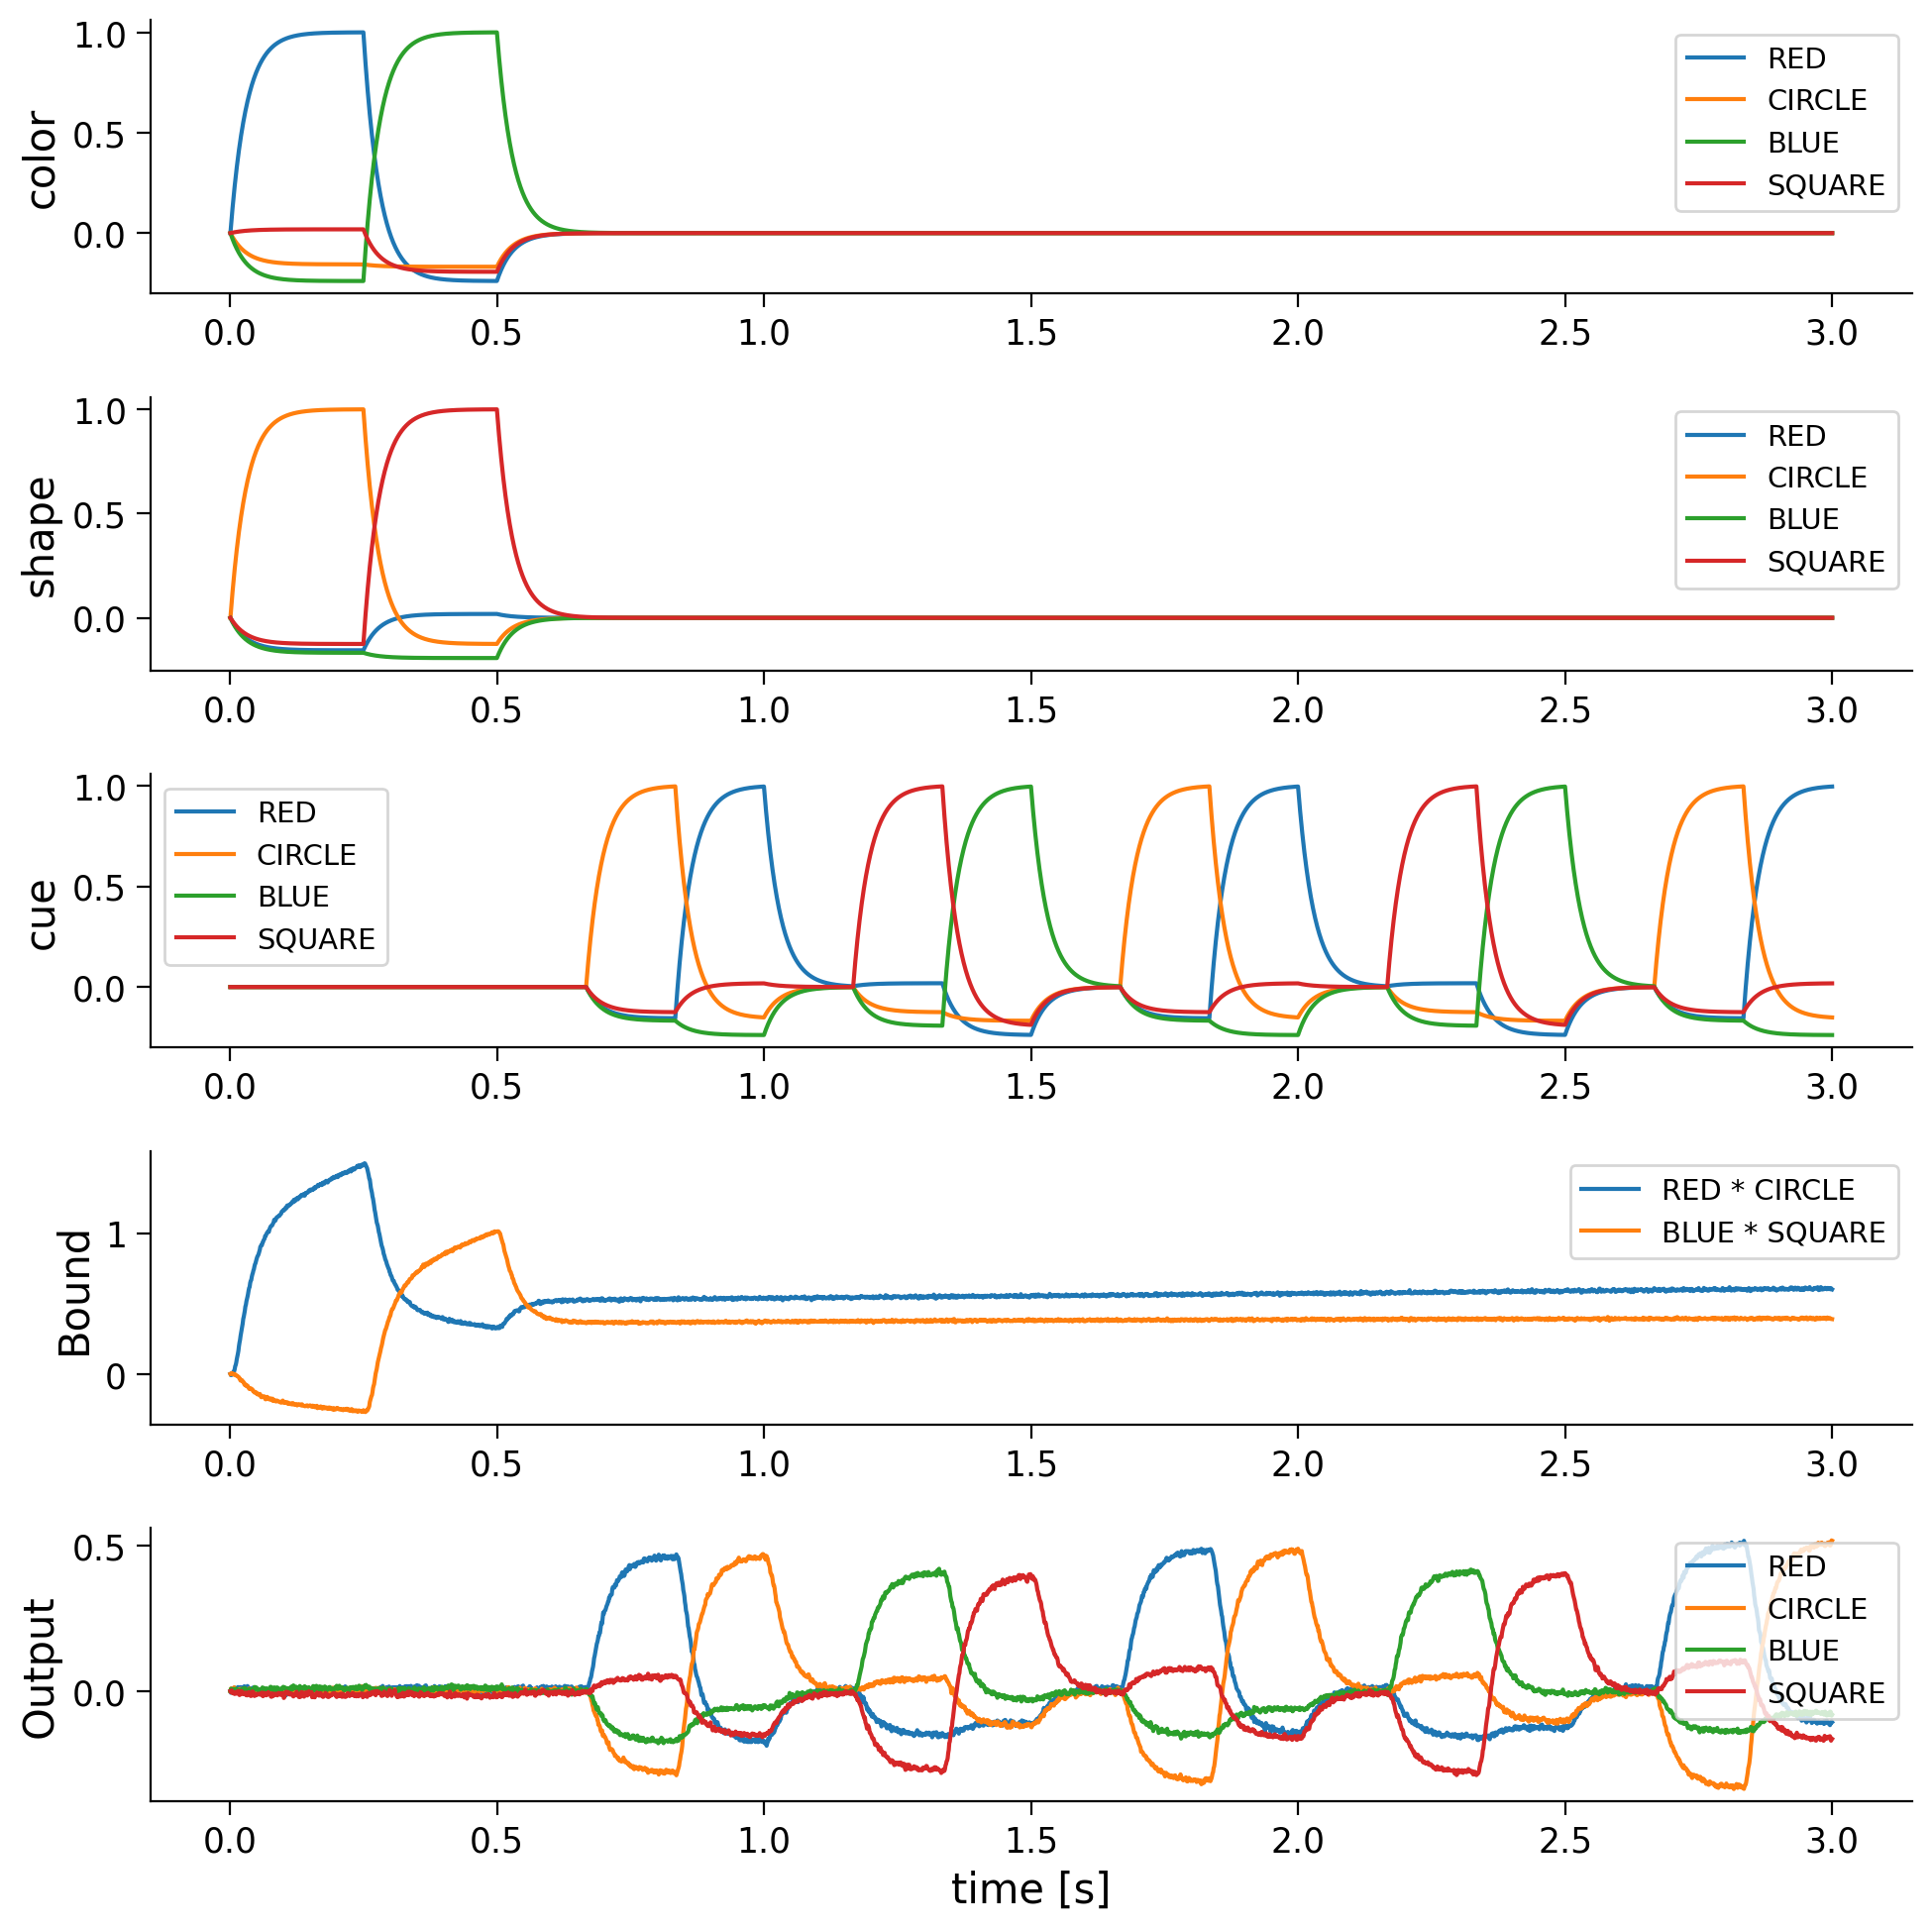

In [10]:
plt.figure(figsize=(10, 10))
vocab = model.vocabs[dimensions]

plt.subplot(5, 1, 1)
plt.plot(sim.trange(), spa.similarity(sim.data[p_color_in], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("color")

plt.subplot(5, 1, 2)
plt.plot(sim.trange(), spa.similarity(sim.data[p_shape_in], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("shape")

plt.subplot(5, 1, 3)
plt.plot(sim.trange(), spa.similarity(sim.data[p_cue], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("cue")

plt.subplot(5, 1, 4)
for pointer in ["RED * CIRCLE", "BLUE * SQUARE"]:
    plt.plot(sim.trange(), vocab.parse(pointer).dot(sim.data[p_bound].T), label=pointer)
plt.legend(fontsize="x-small")
plt.ylabel("Bound")

plt.subplot(5, 1, 5)
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("Output")
plt.xlabel("time [s]")

The plots of shape, color, and convolved show that first `RED * CIRCLE` and then `BLUE * SQUARE` will be loaded into the convolved buffer so after 0.5 seconds it represents the superposition `RED * CIRCLE + BLUE * SQUARE`.

The last plot shows that the output is most similar to the semantic pointer bound to the current cue. For example, when RED and CIRCLE are being convolved and the cue is CIRCLE, the output is most similar to RED. Thus, it is possible to unbind semantic pointers from the superposition stored in convolved.

You can see the effect of the memory unit in the model above because, even after the stimulus is turned off, the model is still able to answer the questions posed to it by the ``cue`` element.

You can also see the effect of the neural implementation in the noise in the output signal.


In [11]:
# @title Video 4: Results Walthrough

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '3f0UqEm9Gzo'), ('Bilibili', 'BV17K7jzNEr3')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_results_walkthrough")

## Coding Exercise

**QUESTION** Try adding the concept of a ``GREEN * SQUARE`` to the model. Run the simulation for 5 seconds and compare the plots.

In [ ]:
# Student code completion here

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_green_square_coding")

---

In [ ]:
# @title Video 5: Outro Video

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'mWIfBl-4FKM'), ('Bilibili', 'BV1jK7jzNE1h')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_outro")

---
# The Big Picture

You have now built a fairly simple cognitive model.  A system that has an, albeit limited, vocabulary, expressed using a Vector Symbolic Algebra (VSA).  Also, importantly, it is able to answer questions about it's experience, even though the experience has passed, thanks to its working memory.  Working memory is a vital component of cognitive models, and while this is a simple system, you have now experienced working with the tools that underly SPAUN, the world's largest *functional* brain model.  

Additionally, while you haven't explicitly worked with them, this model was implemented completely with spiking neurons.  The Neural Engineering Framework, the mathematical tools that underpin Nengo, allow us to compile the program we wrote using the VSA into a network of neurons.  If you look closely at the plots above, you can see that the lines are noisy.  This is because they are smoothed (thanks to the probes' synapse) signals that represent the activity of the populations of neurons that implement our simple question answering model.

We have not one, but two extra bonus tutorials for today. These tutorials go into more depth on the basics around how to implement the notions of analogies in a VSA (Bonus Tutorial 4) and in Bonus Tutorial 5 we go through representations in continuous space. If you have any time left over, we encourage you to work your way through this extra material.